In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Bidirectional, LSTM, Dropout, Dense, Input
)
from tensorflow.keras.optimizers import Adam

# ============================================================================
# 1) MODEL BUILDER
# ============================================================================
class LSTMModelBuilder:
    def __init__(self,
                 input_shape,
                 n_classes,
                 lr=1e-4,
                 lstm_units=128,
                 dropout_rates=(0.5, 0.2, 0.1),
                 num_layers=2,
                 bidirectional=False):
        """
        input_shape: tuple, e.g. (timesteps, features)
        n_classes: int
        lr: learning rate
        lstm_units: hidden size of each LSTM
        dropout_rates: sequence of floats length (num_layers + 1):
                       first num_layers rates for after each LSTM,
                       last rate for after the Dense head
        num_layers: how many LSTM layers to stack
        bidirectional: wrap each LSTM in Bidirectional if True
        """
        self.input_shape   = input_shape
        self.n_classes     = n_classes
        self.lr            = lr
        self.lstm_units    = lstm_units
        self.num_layers    = num_layers
        self.bidirectional = bidirectional

        # normalize dropout_rates to a tuple of length num_layers+1
        dr = tuple(dropout_rates)
        if len(dr) != num_layers + 1:
            raise ValueError(f"dropout_rates must have length num_layers+1 = {num_layers+1}")
        self.dropout_rates = dr

    def build(self):
        m = Sequential()
        LAYER = lambda **kw: (
            Bidirectional(LSTM(self.lstm_units, **kw))
            if self.bidirectional
            else LSTM(self.lstm_units, **kw)
        )

        # stack LSTM + Dropout layers
        for i in range(self.num_layers):
            return_seq = (i < self.num_layers - 1)
            if i == 0:
                m.add(LAYER(input_shape=self.input_shape, return_sequences=return_seq))
            else:
                m.add(LAYER(return_sequences=return_seq))
            m.add(Dropout(self.dropout_rates[i]))

        # dense head + final dropout
        m.add(Dense(self.lstm_units, activation="relu"))
        m.add(Dropout(self.dropout_rates[-1]))

        # output
        m.add(Dense(self.n_classes, activation="softmax"))

        m.compile(
            optimizer=Adam(learning_rate=self.lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        return m

    @staticmethod
    def upsample_sequences(X, target_len):
        """Resample axis-1 to `target_len` timesteps."""
        return resample(X, target_len, axis=1)


# ============================================================================
# 2) TRAIN / EVAL / PLOTTING PIPELINE
# ============================================================================
class SignalClassifierTrainer:
    def __init__(self, model_builder, snr_threshold=-6,
                 test_size=0.2, random_state=42):
        """
        model_builder: instance of LSTMModelBuilder
        snr_threshold: drop samples below this SNR
        test_size, random_state: for train/test split
        """
        self.mb           = model_builder
        self.snr_thresh   = snr_threshold
        self.test_size    = test_size
        self.random_state = random_state

        # Will be filled in load_data()
        self.raw_data = None
        self.X, self.y = None, None
        self.le       = None
        self.X_tr, self.X_te, self.y_tr, self.y_te = (None,)*4
        self.model    = None
        self.history  = None

    def load_data(self, path):
        """Loads RML2016.10a_dict.pkl and builds X,y arrays."""
        with open(path, "rb") as f:
            data = pickle.load(f, encoding="latin1")
        self.raw_data = data

        X_list, y_list = [], []
        for (mod, S), sigs in data.items():
            if S < self.snr_thresh:
                continue
            for sig in sigs:
                iq   = np.vstack([sig[0], sig[1]]).T  # (T,2)
                s_col= np.full((iq.shape[0],1), S, dtype=np.float32)
                X_list.append(np.hstack([iq, s_col])) # (T,3)
                y_list.append(mod)

        X = np.array(X_list, dtype=np.float32)
        y = np.array(y_list)

        # optionally upsample if builder.input_shape[0] != X.shape[1]
        T_desired = self.mb.input_shape[0]
        if X.shape[1] != T_desired:
            X = self.mb.upsample_sequences(X, T_desired)

        # encode
        le     = LabelEncoder()
        y_enc  = le.fit_transform(y)

        self.X, self.y = X, y_enc
        self.le       = le

    def split_data(self):
        """Stratified train/test split."""
        self.X_tr, self.X_te, self.y_tr, self.y_te = train_test_split(
            self.X, self.y,
            test_size=self.test_size,
            stratify=self.y,
            random_state=self.random_state
        )

    def build_model(self):
        """Use the builder to get a compiled model."""
        self.model = self.mb.build()

    def train(self, epochs=100, batch_size=64, verbose=2):
        """Fit and store history."""
        self.history = self.model.fit(
            self.X_tr, self.y_tr,
            validation_data=(self.X_te, self.y_te),
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose
        )

    def plot_training_history(self):
        """Plot accuracy curves."""
        plt.figure(figsize=(6,4))
        plt.plot(self.history.history["accuracy"], label="Train")
        plt.plot(self.history.history["val_accuracy"], label="Val")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.title("Training & Validation Accuracy")
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.show()

    def evaluate(self):
        """Print classification report on test set."""
        y_prob = self.model.predict(self.X_te, verbose=0)
        y_pred = np.argmax(y_prob, axis=1)
        print("\nClassification Report:")
        print(classification_report(
            self.y_te, y_pred, target_names=self.le.classes_
        ))
        return y_pred

    def plot_confusion_matrix(self):
        """Show a heatmap of the confusion matrix."""
        y_pred = np.argmax(self.model.predict(self.X_te, verbose=0), axis=1)
        cm = confusion_matrix(self.y_te, y_pred)
        plt.figure(figsize=(10,8))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=self.le.classes_,
            yticklabels=self.le.classes_
        )
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.tight_layout(); plt.show()

    def plot_accuracy_vs_snr(self, snr_values):
        """Rebuild per-SNR accuracy curve."""
        acc_per_snr = []
        for S in snr_values:
            X_s, y_s = [], []
            for (mod_val, s_val), sigs in self.raw_data.items():
                if s_val != S:
                    continue
                for sig in sigs:
                    iq    = np.vstack([sig[0], sig[1]]).T
                    s_col = np.full((iq.shape[0],1), s_val, dtype=np.float32)
                    X_s.append(np.hstack([iq, s_col]))
                    y_s.append(mod_val)

            if not X_s:
                acc_per_snr.append(np.nan)
                continue

            X_s = np.array(X_s, dtype=np.float32)
            # upsample if needed
            if X_s.shape[1] != self.mb.input_shape[0]:
                X_s = self.mb.upsample_sequences(
                    X_s, self.mb.input_shape[0]
                )
            y_s_enc = self.le.transform(y_s)
            preds = self.model.predict(X_s, verbose=0).argmax(axis=1)
            acc_per_snr.append((preds == y_s_enc).mean())

        plt.figure(figsize=(7,4))
        plt.plot(snr_values, acc_per_snr, marker="o")
        plt.xlabel("SNR [dB]"); plt.ylabel("Accuracy")
        plt.title("Accuracy vs SNR")
        plt.ylim(0,1.05); plt.grid(True); plt.tight_layout()
        plt.show()


# ============================================================================
# 3) USAGE
# ============================================================================




I0000 00:00:1745704470.236312 3329288 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1041 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:4a:00.0, compute capability: 8.0
/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


I0000 00:00:1745704472.217524 3329573 cuda_dnn.cc:529] Loaded cuDNN version 90300


1788/1788 - 42s - 23ms/step - accuracy: 0.0901 - loss: 2.4011 - val_accuracy: 0.0901 - val_loss: 2.3984
Epoch 2/100
1788/1788 - 39s - 22ms/step - accuracy: 0.0901 - loss: 2.3990 - val_accuracy: 0.0943 - val_loss: 2.3980
Epoch 3/100
1788/1788 - 24s - 14ms/step - accuracy: 0.0910 - loss: 2.3984 - val_accuracy: 0.0887 - val_loss: 2.3980
Epoch 4/100
1788/1788 - 37s - 21ms/step - accuracy: 0.0983 - loss: 2.3922 - val_accuracy: 0.0938 - val_loss: 2.3779
Epoch 5/100
1788/1788 - 38s - 21ms/step - accuracy: 0.1095 - loss: 2.3495 - val_accuracy: 0.1131 - val_loss: 2.3350
Epoch 6/100
1788/1788 - 38s - 21ms/step - accuracy: 0.1306 - loss: 2.2699 - val_accuracy: 0.1167 - val_loss: 2.3420
Epoch 7/100
1788/1788 - 38s - 21ms/step - accuracy: 0.1860 - loss: 2.1063 - val_accuracy: 0.1987 - val_loss: 2.0725
Epoch 8/100
1788/1788 - 38s - 21ms/step - accuracy: 0.2118 - loss: 2.0541 - val_accuracy: 0.2226 - val_loss: 2.0312
Epoch 9/100
1788/1788 - 38s - 21ms/step - accuracy: 0.2079 - loss: 2.0803 - val_accu

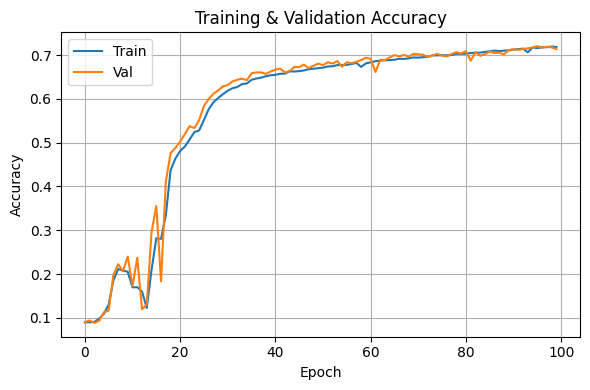


Classification Report:
              precision    recall  f1-score   support

        8PSK       0.51      0.71      0.60      2600
      AM-DSB       0.59      0.96      0.73      2600
      AM-SSB       0.86      0.97      0.91      2600
        BPSK       0.86      0.81      0.84      2600
       CPFSK       0.87      0.88      0.88      2600
        GFSK       0.90      0.93      0.91      2600
        PAM4       0.88      0.81      0.84      2600
       QAM16       0.45      0.30      0.36      2600
       QAM64       0.53      0.51      0.52      2600
        QPSK       0.68      0.65      0.67      2600
        WBFM       0.88      0.31      0.46      2600

    accuracy                           0.71     28600
   macro avg       0.73      0.71      0.70     28600
weighted avg       0.73      0.71      0.70     28600



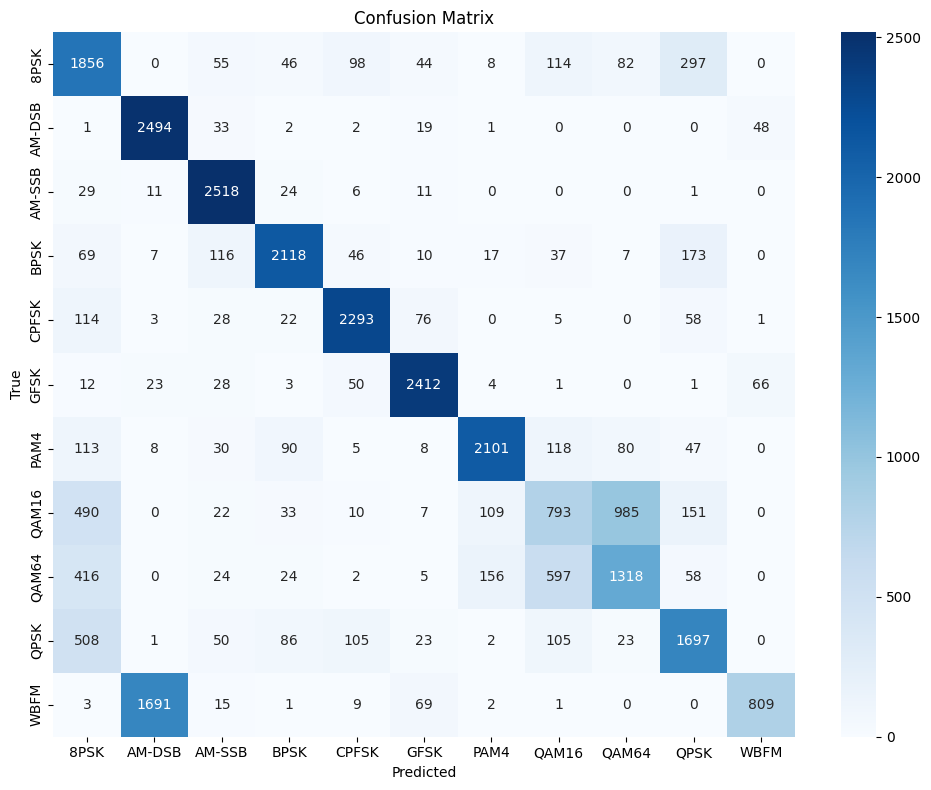

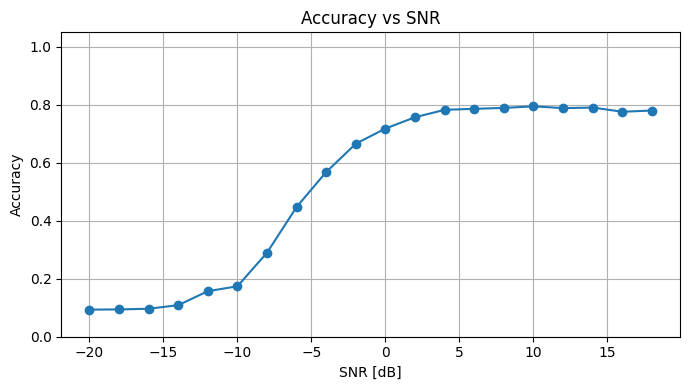

✅ Model saved to saved_models/signal_classifier_final.keras

>>> Training config: Uni-3L-128U
Epoch 1/50


/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1788/1788 - 54s - 30ms/step - accuracy: 0.0903 - loss: 2.4005 - val_accuracy: 0.0901 - val_loss: 2.3982
Epoch 2/50
1788/1788 - 49s - 28ms/step - accuracy: 0.0911 - loss: 2.3990 - val_accuracy: 0.0915 - val_loss: 2.3982
Epoch 3/50
1788/1788 - 54s - 30ms/step - accuracy: 0.0915 - loss: 2.3987 - val_accuracy: 0.0900 - val_loss: 2.3982
Epoch 4/50
1788/1788 - 55s - 31ms/step - accuracy: 0.0902 - loss: 2.3983 - val_accuracy: 0.0918 - val_loss: 2.3976
Epoch 5/50
1788/1788 - 56s - 31ms/step - accuracy: 0.1080 - loss: 2.3586 - val_accuracy: 0.1336 - val_loss: 2.2510
Epoch 6/50
1788/1788 - 55s - 31ms/step - accuracy: 0.1531 - loss: 2.1870 - val_accuracy: 0.1640 - val_loss: 2.1745
Epoch 7/50
1788/1788 - 49s - 28ms/step - accuracy: 0.1926 - loss: 2.0889 - val_accuracy: 0.2106 - val_loss: 2.0325
Epoch 8/50
1788/1788 - 32s - 18ms/step - accuracy: 0.2132 - loss: 2.0671 - val_accuracy: 0.2049 - val_loss: 2.1466
Epoch 9/50
1788/1788 - 27s - 15ms/step - accuracy: 0.1494 - loss: 2.2519 - val_accuracy: 0.

/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1788/1788 - 34s - 19ms/step - accuracy: 0.0917 - loss: 2.4010 - val_accuracy: 0.0933 - val_loss: 2.3986
Epoch 2/50
1788/1788 - 32s - 18ms/step - accuracy: 0.0897 - loss: 2.3992 - val_accuracy: 0.0964 - val_loss: 2.3982
Epoch 3/50
1788/1788 - 32s - 18ms/step - accuracy: 0.0943 - loss: 2.3972 - val_accuracy: 0.1048 - val_loss: 2.3837
Epoch 4/50
1788/1788 - 32s - 18ms/step - accuracy: 0.1175 - loss: 2.3259 - val_accuracy: 0.1725 - val_loss: 2.1699
Epoch 5/50
1788/1788 - 32s - 18ms/step - accuracy: 0.1826 - loss: 2.1179 - val_accuracy: 0.2119 - val_loss: 2.0324
Epoch 6/50
1788/1788 - 32s - 18ms/step - accuracy: 0.1839 - loss: 2.1372 - val_accuracy: 0.2029 - val_loss: 2.0860
Epoch 7/50
1788/1788 - 32s - 18ms/step - accuracy: 0.1873 - loss: 2.1094 - val_accuracy: 0.2137 - val_loss: 2.0281
Epoch 8/50
1788/1788 - 32s - 18ms/step - accuracy: 0.1894 - loss: 2.1474 - val_accuracy: 0.2527 - val_loss: 1.9509
Epoch 9/50
1788/1788 - 32s - 18ms/step - accuracy: 0.2631 - loss: 1.9266 - val_accuracy: 0.

/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1788/1788 - 49s - 27ms/step - accuracy: 0.0891 - loss: 2.4025 - val_accuracy: 0.0905 - val_loss: 2.3992
Epoch 2/50
1788/1788 - 48s - 27ms/step - accuracy: 0.0917 - loss: 2.3995 - val_accuracy: 0.0902 - val_loss: 2.3984
Epoch 3/50
1788/1788 - 48s - 27ms/step - accuracy: 0.0965 - loss: 2.3955 - val_accuracy: 0.1023 - val_loss: 2.3909
Epoch 4/50
1788/1788 - 48s - 27ms/step - accuracy: 0.0958 - loss: 2.3971 - val_accuracy: 0.1027 - val_loss: 2.3914
Epoch 5/50
1788/1788 - 48s - 27ms/step - accuracy: 0.0943 - loss: 2.3964 - val_accuracy: 0.0935 - val_loss: 2.3978
Epoch 6/50
1788/1788 - 48s - 27ms/step - accuracy: 0.0908 - loss: 2.3991 - val_accuracy: 0.0909 - val_loss: 2.3979
Epoch 7/50
1788/1788 - 48s - 27ms/step - accuracy: 0.0910 - loss: 2.3983 - val_accuracy: 0.0909 - val_loss: 2.3981
Epoch 8/50
1788/1788 - 48s - 27ms/step - accuracy: 0.0904 - loss: 2.3984 - val_accuracy: 0.0909 - val_loss: 2.3980
Epoch 9/50
1788/1788 - 48s - 27ms/step - accuracy: 0.0904 - loss: 2.3983 - val_a

/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


2025-04-26 20:39:15.835644: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 234.75MiB (rounded to 246153984)requested by op StatefulPartitionedCall/sequential_4_1/lstm_12_1/CudnnRNNV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-04-26 20:39:15.835703: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2025-04-26 20:39:15.835710: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 1119, Chunks in use: 1116. 279.8KiB allocated for chunks. 279.0KiB in use in bin. 5.9KiB client-requested in use in bin.
2025-04-26 20:39:15.835714: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 8, Chunks in use: 7. 4.5KiB allocated for chunks. 3.8KiB in use

InternalError: Graph execution error:

Detected at node sequential_4_1/lstm_12_1/CudnnRNNV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/apps/easybuild/software/falcon-sapphirerapids/jupyter-server/2.14.0-GCCcore-13.2.0/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/apps/easybuild/software/falcon-sapphirerapids/IPython/8.17.2-GCCcore-13.2.0/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/apps/easybuild/software/falcon-sapphirerapids/jupyter-server/2.14.0-GCCcore-13.2.0/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/apps/easybuild/software/falcon-sapphirerapids/tornado/6.4-GCCcore-13.2.0/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/apps/easybuild/software/falcon-sapphirerapids/jupyter-server/2.14.0-GCCcore-13.2.0/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/apps/easybuild/software/falcon-sapphirerapids/jupyter-server/2.14.0-GCCcore-13.2.0/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/apps/easybuild/software/falcon-sapphirerapids/jupyter-server/2.14.0-GCCcore-13.2.0/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/apps/easybuild/software/falcon-sapphirerapids/jupyter-server/2.14.0-GCCcore-13.2.0/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/apps/easybuild/software/falcon-sapphirerapids/jupyter-server/2.14.0-GCCcore-13.2.0/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/apps/easybuild/software/falcon-sapphirerapids/jupyter-server/2.14.0-GCCcore-13.2.0/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/apps/easybuild/software/falcon-sapphirerapids/jupyter-server/2.14.0-GCCcore-13.2.0/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/apps/easybuild/software/falcon-sapphirerapids/IPython/8.17.2-GCCcore-13.2.0/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/apps/easybuild/software/falcon-sapphirerapids/IPython/8.17.2-GCCcore-13.2.0/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/apps/easybuild/software/falcon-sapphirerapids/IPython/8.17.2-GCCcore-13.2.0/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/apps/easybuild/software/falcon-sapphirerapids/IPython/8.17.2-GCCcore-13.2.0/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/apps/easybuild/software/falcon-sapphirerapids/IPython/8.17.2-GCCcore-13.2.0/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/apps/easybuild/software/falcon-sapphirerapids/IPython/8.17.2-GCCcore-13.2.0/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/localscratch/19502/ipykernel_3329288/1455908386.py", line 82, in <module>

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/models/sequential.py", line 221, in call

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/models/functional.py", line 183, in call

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/models/functional.py", line 643, in call

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/rnn/lstm.py", line 584, in call

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py", line 408, in call

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/rnn/lstm.py", line 551, in inner_loop

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

Failed to call DoRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 1024, 1024, 1, 128, 64, 1024] 
	 [[{{node sequential_4_1/lstm_12_1/CudnnRNNV3}}]] [Op:__inference_multi_step_on_iterator_2481343]

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell: Grid search + plot Accuracy vs SNR for each config
# ─────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


DATA_PATH = "RML2016.10a_dict.pkl"

# 1) instantiate builder (use original 128-step, 128 units, bidirectional)
builder = LSTMModelBuilder(
    input_shape=(128,3),
    n_classes=None,       # we'll fill this after loading data
    lr=1e-4,
    lstm_units=128,
    dropout_rates=(0.5,0.2,0.1),
    bidirectional=False
)

# 2) trainer
trainer = SignalClassifierTrainer(builder, snr_threshold=-6)

# 3) load & encode
trainer.load_data(DATA_PATH)
builder.n_classes = trainer.le.classes_.shape[0]  # now we know n_classes

# 4) split
trainer.split_data()

# 5) build, train
trainer.build_model()
trainer.train(epochs=100, batch_size=64)

# 6) plots & evaluation
trainer.plot_training_history()
trainer.evaluate()
trainer.plot_confusion_matrix()
trainer.plot_accuracy_vs_snr(list(range(-20,22,2)))

# choose a directory & filename
save_dir  = "saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "signal_classifier_final.keras")

# save the entire model (architecture + weights + optimizer state)
trainer.model.save(model_path)
print(f"✅ Model saved to {model_path}")


# Hyperparameter ranges
num_layers_list    = [3, 4, 5, 6]
lstm_units_list    = [128, 256, 512, 1024, 2048]
bidirectional_opts = [False, True]

# SNR values to evaluate
snr_values = list(range(-20, 22, 2))

# Collect results
results = []

for bidir in bidirectional_opts:
    for num_layers in num_layers_list:
        for units in lstm_units_list:
            config_label = f"{'Bi' if bidir else 'Uni'}-{num_layers}L-{units}U"
            print(f"\n>>> Training config: {config_label}")

            # 1) Rebuild model for this config
            builder = LSTMModelBuilder(
                input_shape=trainer.mb.input_shape,
                n_classes=trainer.mb.n_classes,
                lr=1e-4,
                lstm_units=units,
                num_layers=num_layers,
                dropout_rates=tuple([0.5]*num_layers + [0.1]),
                bidirectional=bidir
            )
            trainer.mb = builder
            trainer.build_model()

            # 2) Train for 50 epochs
            hist = trainer.model.fit(
                trainer.X_tr, trainer.y_tr,
                validation_data=(trainer.X_te, trainer.y_te),
                epochs=50,
                batch_size=64,
                verbose=2
            )
            final_val_acc = hist.history['val_accuracy'][-1]

            # 3) Compute accuracy per SNR
            acc_per_snr = []
            for S in snr_values:
                X_s, y_s = [], []
                for (mod_val, s_val), sigs in trainer.raw_data.items():
                    if s_val != S:
                        continue
                    for sig in sigs:
                        iq    = np.vstack([sig[0], sig[1]]).T
                        s_col = np.full((iq.shape[0],1), s_val, dtype=np.float32)
                        X_s.append(np.hstack([iq, s_col]))
                        y_s.append(mod_val)

                if not X_s:
                    acc_per_snr.append(np.nan)
                    continue

                X_s = np.array(X_s, dtype=np.float32)
                if X_s.shape[1] != builder.input_shape[0]:
                    X_s = builder.upsample_sequences(X_s, builder.input_shape[0])
                y_s_enc = trainer.le.transform(y_s)
                preds   = trainer.model.predict(X_s, verbose=0).argmax(axis=1)
                acc_per_snr.append((preds == y_s_enc).mean())

            # 4) Store
            results.append({
                'config':     config_label,
                'bidirectional': bidir,
                'num_layers': num_layers,
                'lstm_units': units,
                'val_accuracy': final_val_acc,
                'snr_acc':    acc_per_snr
            })

# Convert to DataFrame for final val_accuracy ranking
df = pd.DataFrame(results)
df = df.sort_values('val_accuracy', ascending=False).reset_index(drop=True)
print("\nTop 10 by validation accuracy:")
print(df[['config','val_accuracy']].head(10))

# Plot Accuracy vs SNR for each configuration
plt.figure(figsize=(12, 8))
for row in results:
    plt.plot(
        snr_values, row['snr_acc'],
        label=row['config']
    )
plt.xlabel("SNR [dB]")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR for Each Hyperparameter Configuration")
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize='small',
    ncol=1
)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from scipy.signal import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Bidirectional, LSTM, Dropout, Dense, Input
)
from tensorflow.keras.optimizers import Adam

# ============================================================================
# 1) MODEL BUILDER
# ============================================================================
class LSTMModelBuilder:
    def __init__(self,
                 input_shape,
                 n_classes,
                 lr=1e-4,
                 lstm_units=128,
                 dropout_rates=(0.5, 0.2, 0.1),
                 bidirectional=False):
        """
        input_shape: tuple, e.g. (timesteps, features)
        n_classes: int
        lr: learning rate
        lstm_units: hidden size of each LSTM
        dropout_rates: tuple of three floats for
                       (after 1st LSTM, after 2nd LSTM, after Dense)
        bidirectional: wrap LSTMs in Bidirectional if True
        """
        self.input_shape   = input_shape
        self.n_classes     = n_classes
        self.lr            = lr
        self.lstm_units    = lstm_units
        self.dr1, self.dr2, self.dr3 = dropout_rates
        self.bidirectional = bidirectional

    def build(self):
        m = Sequential()
        LAYER = lambda **kw: (
            Bidirectional(LSTM(self.lstm_units, **kw))
            if self.bidirectional
            else LSTM(self.lstm_units, **kw)
        )

        # first LSTM (keep sequences)
        m.add(LAYER(input_shape=self.input_shape, return_sequences=True))
        m.add(Dropout(self.dr1))

        # second LSTM (no sequences out)
        m.add(LAYER(return_sequences=False))
        m.add(Dropout(self.dr2))

        # dense head
        m.add(Dense(self.lstm_units, activation="relu"))
        m.add(Dropout(self.dr3))

        # final softmax
        m.add(Dense(self.n_classes, activation="softmax"))

        m.compile(
            optimizer=Adam(learning_rate=self.lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        return m

    @staticmethod
    def upsample_sequences(X, target_len):
        """Resample axis-1 to `target_len` timesteps."""
        return resample(X, target_len, axis=1)


# ============================================================================
# 2) TRAIN / EVAL / PLOTTING PIPELINE
# ============================================================================
class SignalClassifierTrainer:
    def __init__(self, model_builder, snr_threshold=-6,
                 test_size=0.2, random_state=42):
        """
        model_builder: instance of LSTMModelBuilder
        snr_threshold: drop samples below this SNR
        test_size, random_state: for train/test split
        """
        self.mb           = model_builder
        self.snr_thresh   = snr_threshold
        self.test_size    = test_size
        self.random_state = random_state

        # Will be filled in load_data()
        self.raw_data = None
        self.X, self.y = None, None
        self.le       = None
        self.X_tr, self.X_te, self.y_tr, self.y_te = (None,)*4
        self.model    = None
        self.history  = None

    def load_data(self, path):
        """Loads RML2016.10a_dict.pkl and builds X,y arrays."""
        with open(path, "rb") as f:
            data = pickle.load(f, encoding="latin1")
        self.raw_data = data

        X_list, y_list = [], []
        for (mod, S), sigs in data.items():
            if S < self.snr_thresh:
                continue
            for sig in sigs:
                iq   = np.vstack([sig[0], sig[1]]).T  # (T,2)
                s_col= np.full((iq.shape[0],1), S, dtype=np.float32)
                X_list.append(np.hstack([iq, s_col])) # (T,3)
                y_list.append(mod)

        X = np.array(X_list, dtype=np.float32)
        y = np.array(y_list)

        # optionally upsample if builder.input_shape[0] != X.shape[1]
        T_desired = self.mb.input_shape[0]
        if X.shape[1] != T_desired:
            X = self.mb.upsample_sequences(X, T_desired)

        # encode
        le     = LabelEncoder()
        y_enc  = le.fit_transform(y)

        self.X, self.y = X, y_enc
        self.le       = le

    def split_data(self):
        """Stratified train/test split."""
        self.X_tr, self.X_te, self.y_tr, self.y_te = train_test_split(
            self.X, self.y,
            test_size=self.test_size,
            stratify=self.y,
            random_state=self.random_state
        )

    def build_model(self):
        """Use the builder to get a compiled model."""
        self.model = self.mb.build()

    def train(self, epochs=100, batch_size=64, verbose=2):
        """Fit and store history."""
        self.history = self.model.fit(
            self.X_tr, self.y_tr,
            validation_data=(self.X_te, self.y_te),
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose
        )

    def plot_training_history(self):
        """Plot accuracy curves."""
        plt.figure(figsize=(6,4))
        plt.plot(self.history.history["accuracy"], label="Train")
        plt.plot(self.history.history["val_accuracy"], label="Val")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.title("Training & Validation Accuracy")
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.show()

    def evaluate(self):
        """Print classification report on test set."""
        y_prob = self.model.predict(self.X_te, verbose=0)
        y_pred = np.argmax(y_prob, axis=1)
        print("\nClassification Report:")
        print(classification_report(
            self.y_te, y_pred, target_names=self.le.classes_
        ))
        return y_pred

    def plot_confusion_matrix(self):
        """Show a heatmap of the confusion matrix."""
        y_pred = np.argmax(self.model.predict(self.X_te, verbose=0), axis=1)
        cm = confusion_matrix(self.y_te, y_pred)
        plt.figure(figsize=(10,8))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=self.le.classes_,
            yticklabels=self.le.classes_
        )
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.tight_layout(); plt.show()

    def plot_accuracy_vs_snr(self, snr_values):
        """Rebuild per-SNR accuracy curve."""
        acc_per_snr = []
        for S in snr_values:
            X_s, y_s = [], []
            for (mod_val, s_val), sigs in self.raw_data.items():
                if s_val != S:
                    continue
                for sig in sigs:
                    iq    = np.vstack([sig[0], sig[1]]).T
                    s_col = np.full((iq.shape[0],1), s_val, dtype=np.float32)
                    X_s.append(np.hstack([iq, s_col]))
                    y_s.append(mod_val)

            if not X_s:
                acc_per_snr.append(np.nan)
                continue

            X_s = np.array(X_s, dtype=np.float32)
            # upsample if needed
            if X_s.shape[1] != self.mb.input_shape[0]:
                X_s = self.mb.upsample_sequences(
                    X_s, self.mb.input_shape[0]
                )
            y_s_enc = self.le.transform(y_s)
            preds = self.model.predict(X_s, verbose=0).argmax(axis=1)
            acc_per_snr.append((preds == y_s_enc).mean())

        plt.figure(figsize=(7,4))
        plt.plot(snr_values, acc_per_snr, marker="o")
        plt.xlabel("SNR [dB]"); plt.ylabel("Accuracy")
        plt.title("Accuracy vs SNR")
        plt.ylim(0,1.05); plt.grid(True); plt.tight_layout()
        plt.show()


# ============================================================================
# 3) USAGE
# ============================================================================

if __name__ == "__main__":
    DATA_PATH = "RML2016.10a_dict.pkl"

    # 1) instantiate builder (use original 128-step, 128 units, bidirectional)
    builder = LSTMModelBuilder(
        input_shape=(128,3),
        n_classes=None,       # we'll fill this after loading data
        lr=1e-4,
        lstm_units=512,
        dropout_rates=(0.5,0.2,0.1),
        bidirectional=True
    )

    # 2) trainer
    trainer = SignalClassifierTrainer(builder, snr_threshold=-6)

    # 3) load & encode
    trainer.load_data(DATA_PATH)
    builder.n_classes = trainer.le.classes_.shape[0]  # now we know n_classes

    # 4) split
    trainer.split_data()

    # 5) build, train
    trainer.build_model()
    trainer.train(epochs=100, batch_size=64)

    # 6) plots & evaluation
    trainer.plot_training_history()
    trainer.evaluate()
    trainer.plot_confusion_matrix()
    trainer.plot_accuracy_vs_snr(list(range(-20,22,2)))



2025-04-26 23:20:31.850011: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-26 23:20:31.866050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745724031.879076 2410062 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745724031.882907 2410062 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 23:20:31.896233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch 1/100


I0000 00:00:1745724037.321657 2410062 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21002 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:4a:00.0, compute capability: 8.0
/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1745724040.416798 2410220 cuda_dnn.cc:529] Loaded cuDNN version 90300


1788/1788 - 73s - 41ms/step - accuracy: 0.0904 - loss: 2.4037 - val_accuracy: 0.0899 - val_loss: 2.3994
Epoch 2/100
1788/1788 - 69s - 39ms/step - accuracy: 0.0915 - loss: 2.3987 - val_accuracy: 0.0903 - val_loss: 2.3981
Epoch 3/100
1788/1788 - 69s - 39ms/step - accuracy: 0.0887 - loss: 2.3984 - val_accuracy: 0.0902 - val_loss: 2.3992
Epoch 4/100
1788/1788 - 69s - 39ms/step - accuracy: 0.0916 - loss: 2.3986 - val_accuracy: 0.0909 - val_loss: 2.3979
Epoch 5/100
1788/1788 - 69s - 39ms/step - accuracy: 0.0901 - loss: 2.3981 - val_accuracy: 0.0909 - val_loss: 2.3979
Epoch 6/100
1788/1788 - 69s - 39ms/step - accuracy: 0.0907 - loss: 2.3981 - val_accuracy: 0.0897 - val_loss: 2.3979
Epoch 7/100
1788/1788 - 69s - 39ms/step - accuracy: 0.0903 - loss: 2.3980 - val_accuracy: 0.0908 - val_loss: 2.3981
Epoch 8/100
1788/1788 - 69s - 39ms/step - accuracy: 0.0896 - loss: 2.3981 - val_accuracy: 0.0909 - val_loss: 2.3979
Epoch 9/100
1788/1788 - 69s - 39ms/step - accuracy: 0.0910 - loss: 2.3981 - val_accu

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell: Uni‐directional 3-layer LSTM (256 units), input=128, train on SNR>6 dB, eval all SNR, then save
# ─────────────────────────────────────────────────────────────────────────────
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# 1) Load RML2016.10a dataset
with open("RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# 2) Prepare IQ+SNR sequences
X_list, y_list, snr_list = [], [], []
for (mod, S), sigs in data.items():
    for sig in sigs:
        iq = np.vstack([sig[0], sig[1]]).T        # (128,2)
        s_col = np.full((128,1), S, dtype=np.float32)
        X_list.append(np.hstack([iq, s_col]))     # (128,3)
        y_list.append(mod)
        snr_list.append(S)
X = np.array(X_list, dtype=np.float32)          # (N,128,3)
y = np.array(y_list)
snr = np.array(snr_list)

# 3) Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
n_classes = len(le.classes_)

# 4) Split: train on SNR > 6 dB, evaluate on all
mask_train = snr > 6
X_train = X[mask_train]
y_train = y_enc[mask_train]
X_test  = X
y_test  = y_enc
snr_test = snr

print(f"Training samples (SNR>6): {X_train.shape[0]}, Eval samples: {X_test.shape[0]}")

# 5) Build Uni‐3L‐256U model
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(128,3)),
    Dropout(0.5),
    LSTM(256, return_sequences=True),
    Dropout(0.5),
    LSTM(256, return_sequences=False),
    Dropout(0.2),
    Dense(256, activation="relu"),
    Dropout(0.1),
    Dense(n_classes, activation="softmax")
])
model.compile(
    optimizer=Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# 6) Train for 50 epochs
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    verbose=2
)

# 7) Overall test accuracy
y_pred = model.predict(X_test, verbose=0).argmax(axis=1)
acc_overall = accuracy_score(y_test, y_pred)
print(f"\nOverall test accuracy (all SNR): {acc_overall:.4f}")

# 8) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (All SNR)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# 9) Accuracy vs SNR curve
snr_values = np.unique(snr_test)
acc_per_snr = [
    accuracy_score(y_test[snr_test==S], y_pred[snr_test==S])
    for S in snr_values
]

plt.figure(figsize=(7,4))
plt.plot(snr_values, acc_per_snr, marker="o")
plt.xlabel("SNR [dB]"); plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR (Uni‐3L‐256U)")
plt.grid(True); plt.tight_layout(); plt.show()

# 10) Save the trained model
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "uni_3L_256U.keras")
model.save(model_path)
print(f"✅ Model saved to {model_path}")
